In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

In [3]:

def generate_daily_visitors(mean, sd, days):
    return np.random.normal(mean, sd, days).astype(int)

def generate_daily_purchasers(mean, sd, days):
    return np.random.normal(mean, sd, days).astype(int)


def calculate_z_score(p_control, p_variant, n_control, n_variant):
    p_pool = (p_control * n_control + p_variant * n_variant) / (n_control + n_variant)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_variant))
    return (p_variant - p_control) / se


def calculate_p_value(z_score):
    return norm.sf(abs(z_score)) * 2 


def simulate_aa_test(num_pairs, mean_visitors, sd_visitors, mean_purchasers, sd_purchasers, num_days):
    results = []
    p_values_list = []
    
    for instance in range(1, num_pairs + 1):
        visitors_control = generate_daily_visitors(mean_visitors, sd_visitors, num_days)
        visitors_variant = visitors_control  # Ensuring identical visitor counts
        purchasers_control = generate_daily_purchasers(mean_purchasers, sd_purchasers, num_days)
        purchasers_variant = generate_daily_purchasers(mean_purchasers, sd_purchasers, num_days)
        
        cum_visitors_control, cum_visitors_variant = 0, 0
        cum_purchasers_control, cum_purchasers_variant = 0, 0
        false_positive_duration = False
        false_positive_weekly = False
        false_positive_continuous = False
        false_positive_extended = False
        
        for day in range(1, num_days + 1):
            cum_visitors_control += visitors_control[day - 1]
            cum_visitors_variant += visitors_variant[day - 1]
            cum_purchasers_control += purchasers_control[day - 1]
            cum_purchasers_variant += purchasers_variant[day - 1]
            
            p_control = cum_purchasers_control / cum_visitors_control
            p_variant = cum_purchasers_variant / cum_visitors_variant
            
            z_score = calculate_z_score(p_control, p_variant, cum_visitors_control, cum_visitors_variant)
            p_value = calculate_p_value(z_score)
            
            p_values_list.append({'Day': day, 'Instance': instance, 'P_Value': p_value})
            
            if day == num_days and p_value < 0.05:
                false_positive_duration = True
            if day % 7 == 0 and p_value < 0.05:
                false_positive_weekly = True
            if p_value < 0.05:
                false_positive_continuous = True
            if day > 28 and p_value < 0.05:
                false_positive_extended = True

        results.append({
            'Instance': instance,
            'False_Positive_Duration': false_positive_duration,
            'False_Positive_Weekly': false_positive_weekly,
            'False_Positive_Continuous': false_positive_continuous,
            'False_Positive_Extended': false_positive_extended
        })

    return pd.DataFrame(results), pd.DataFrame(p_values_list)

# Parameters
num_pairs = 10000
mean_visitors = 1000000
sd_visitors = 0
num_days = 35
mean_purchasers = 120000
sd_purchasers = 324.96

# Run simulation
df_results, df_p_values = simulate_aa_test(num_pairs, mean_visitors, sd_visitors, mean_purchasers, sd_purchasers, num_days)

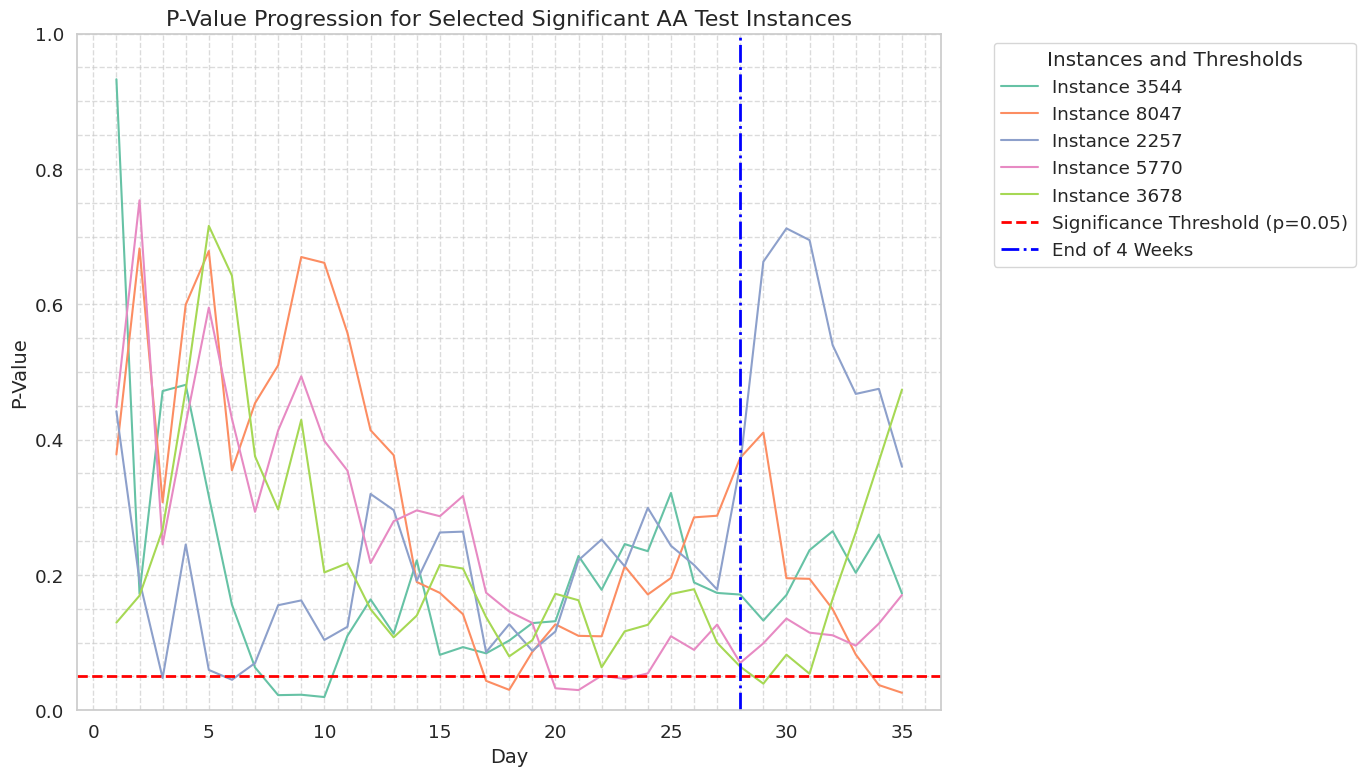

In [4]:

def plot_selected_p_values(df_p_values):
    significant_instances = df_p_values[df_p_values['P_Value'] < 0.05]['Instance'].unique()
    selected_instances = np.random.choice(significant_instances, min(5, len(significant_instances)), replace=False)

    plt.figure(figsize=(14,8))
    colors = sns.color_palette('Set2', len(selected_instances))

    for color, instance in zip(colors, selected_instances):
        instance_data = df_p_values[df_p_values['Instance'] == instance]
        sns.lineplot(data=instance_data, x='Day', y='P_Value', label=f'Instance {instance}', color=color)

    plt.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Significance Threshold (p=0.05)')
    plt.axvline(28, color='blue', linestyle='-.', linewidth=2, label='End of 4 Weeks')
    plt.title('P-Value Progression for Selected Significant AA Test Instances', fontsize=16)
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('P-Value', fontsize=14)
    plt.ylim(0, 1)
    plt.legend(title='Instances and Thresholds', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7, which='both')
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

plot_selected_p_values(df_p_values)

Visual representation

As you can see p-values for AA tests can fluctuate a lot and will regularly cross the signifcatnce threshold during the testing duration. It is clear from the visual example that more instaces would be considered conclusive/signifcant if an p-value during the 4 weeks was considered as would be the case with peeking.

/tmp/ipykernel_63359/1583513105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rates_df, x='Strategy', y='False_Positive_Rate', palette='pastel', edgecolor="black")


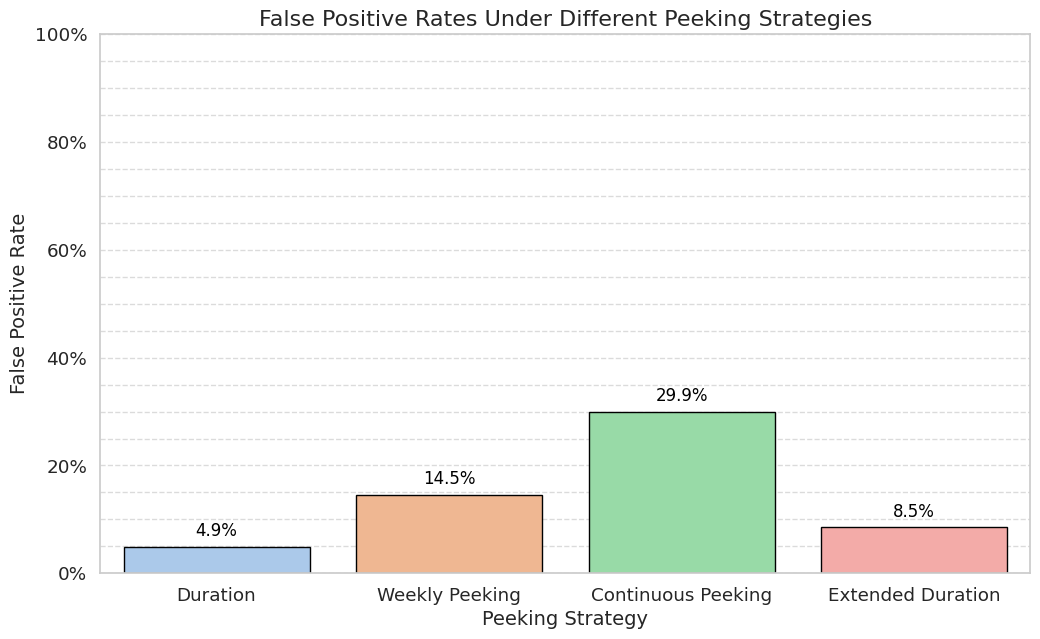

In [5]:

def plot_false_positive_comparison(df):
    false_positive_rates = {
        "Duration": df['False_Positive_Duration'].mean(),
        "Weekly Peeking": df['False_Positive_Weekly'].mean(),
        "Continuous Peeking": df['False_Positive_Continuous'].mean(),
        "Extended Duration": df['False_Positive_Extended'].mean()
    }

    rates_df = pd.DataFrame(list(false_positive_rates.items()), columns=['Strategy', 'False_Positive_Rate'])

    plt.figure(figsize=(12,7))
    ax = sns.barplot(data=rates_df, x='Strategy', y='False_Positive_Rate', palette='pastel', edgecolor="black")
    plt.title('False Positive Rates Under Different Peeking Strategies', fontsize=16)
    plt.ylabel('False Positive Rate', fontsize=14)
    plt.xlabel('Peeking Strategy', fontsize=14)
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height*100:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=12, color='black', xytext=(0,5),
                    textcoords='offset points')

    plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
    plt.minorticks_on()
    plt.show()

plot_false_positive_comparison(df_results)


The Impact

Exactly as we would expect the baseline false postive rate is around 5% as we have chosen the 0.05 critical value.
And you can see even the Extending the duration method leads to 1.7 times the number of false postive in this example. With the two diffeernt times of Peeking leading to 3 times to 6.1 times the baseline. 

The Balance Between Early Insights and Peeking in A/B Testing

In A/B testing, peeking (looking at test results before the planned end) is widely considered bad practice. It increases the risk of false positives, leading to incorrect conclusions and wasted resources. This is because repeated testing without adjusting for multiple looks inflates the overall Type I error rate (false positives).

However, there are valid reasons for wanting interim results:

Business needs might demand faster decisions.

If a test has strong early evidence of harm or success, it is unethical or wasteful to continue.

Resources and opportunity costs make rapid decision-making valuable.

Instead of peeking, proper statistical methods allow for early stopping without inflating the false positive rate. One such method is the O'Brien-Fleming boundary.

O'Brien-Fleming Method

The O'Brien-Fleming method provides adjusted critical p-values for interim analyses. It starts extremely conservative early on (requiring very small p-values to stop the tedt) and becomes less conservative later.

The goal is to maintain the overall Type I error rate (typically 5%) across all looks